<a href="https://colab.research.google.com/github/taimoorsardar/Deep-Learning-Projects/blob/main/ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=7d68236568b8c2efa602cc22edd59f17ecb5cc19ce551d883cb3c93d55c1aef2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=aa1330fca44394b5dad2635d357bd5395572aa380770c7339c80bf915fe795e9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 16.35 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img # additional, not in project video

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
#loading datasets
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

#setting up device
DEVICE = 'cuda'

# hyperparameters (can be changes)
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

# encoder and decoder blocks for our model
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()
# we have seen in the output that
# mask = ground truth        ,        images = input

masks  \
0  Human-Segmentation-Dataset-master/Ground_Truth...   
1  Human-Segmentation-Dataset-master/Ground_Truth...   
2  Human-Segmentation-Dataset-master/Ground_Truth...   
3  Human-Segmentation-Dataset-master/Ground_Truth...   
4  Human-Segmentation-Dataset-master/Ground_Truth...   

                                              images  
0  Human-Segmentation-Dataset-master/Training_Ima...  
1  Human-Segmentation-Dataset-master/Training_Ima...  
2  Human-Segmentation-Dataset-master/Training_Ima...  
3  Human-Segmentation-Dataset-master/Training_Ima...  
4  Human-Segmentation-Dataset-master/Training_Ima...

In [ ]:
# this is for visualization
# as we have seen the paths, we will now use them to see the images

# we are using 4th image as an example
row = df.iloc[0]

#storing paths
image_path = row.images
mask_path = row.masks

# now for reading the image we will use cv2 library functions
image = cv2.imread(image_path)  # this method reads images in bgr format
# we will convert into rgb format, for that we will use
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# same steps for mask, but for segmentation color format is going to be different
mask = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE) / 255.0 # this division is for normalization

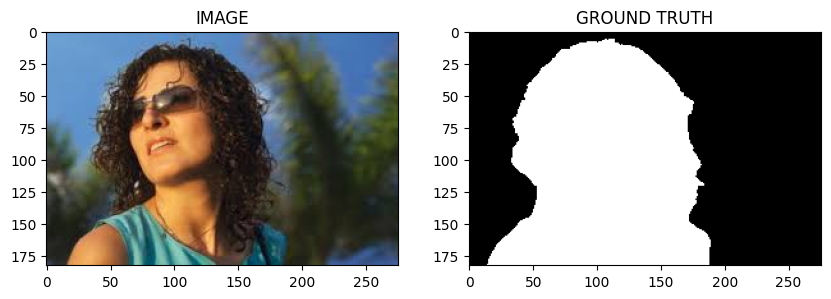

In [ ]:
# VISUALIZATION
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
# splitting the dataset
# random_state is used for random shuffling of data, any values endsures the same way of splitting data every time this method is executed
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
# importing albumentation package, this is used for data augmentation
import albumentations as A

In [ ]:
# a method for training set augmentations
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes = 0)

# a method for valid (test) set augmentations
# no need for horizontal and vertical augmentation
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes = 0)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
   self.df = df
   self.augmentations = augmentations

  # length method for length of dataset
  def __len__(self):
    return len(self.df)

  # This method will return the image and mask pair according to the given index
  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # now its dims are (h,w)
    # we will make it (h,w,c)
    mask = np.expand_dims(mask , axis = -1)

    # now we will add/check tha augmentations
    # returns images and masks in dictionary format
    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # shifting the channels dims towards zero axis bcoz of pytorch convention
    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    # now converting numpy arrays to pytorch tensors
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) /255.0) # rounding the value between 0 and 1 for mask

    return image, mask

In [ ]:
# now lets use the above class (and methods) for train and valid dataset
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


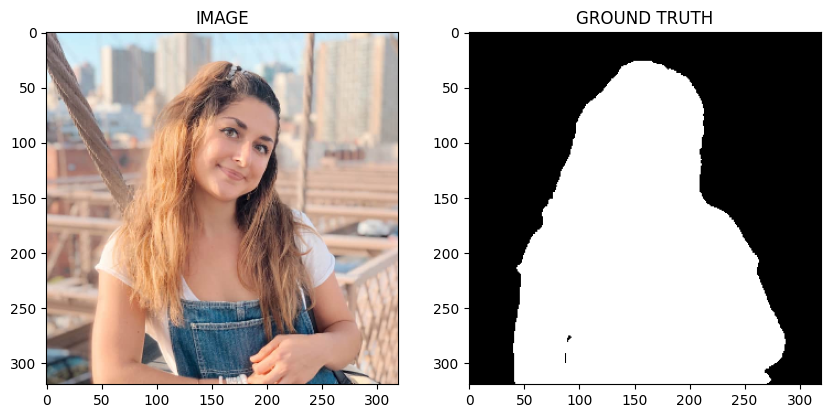

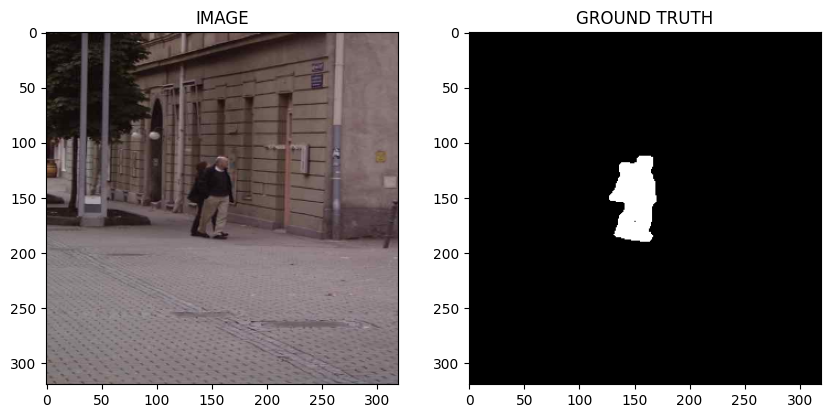

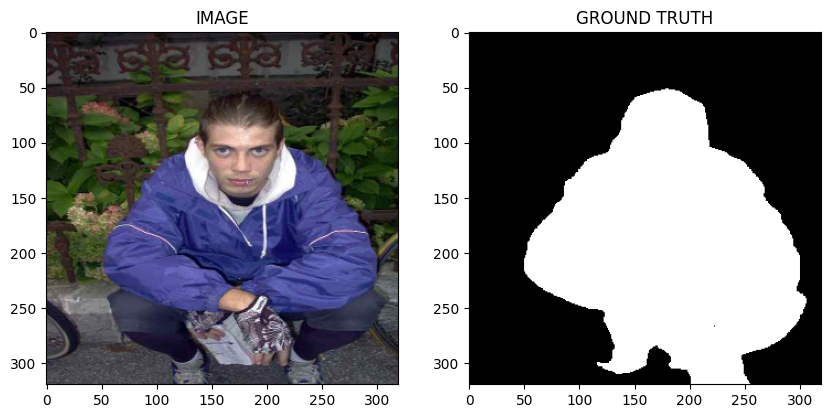

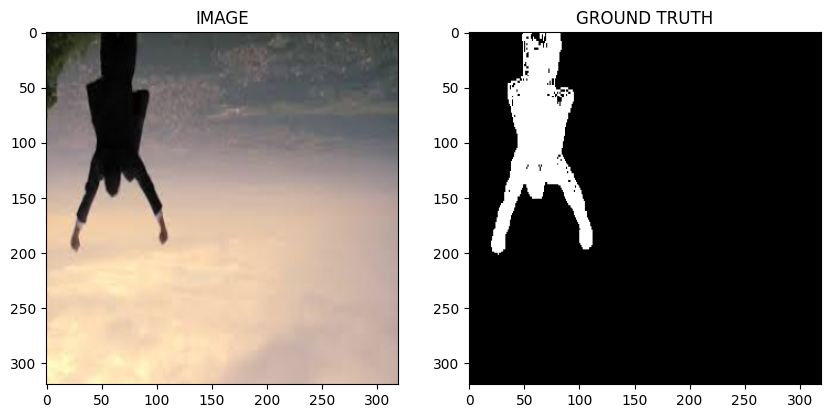

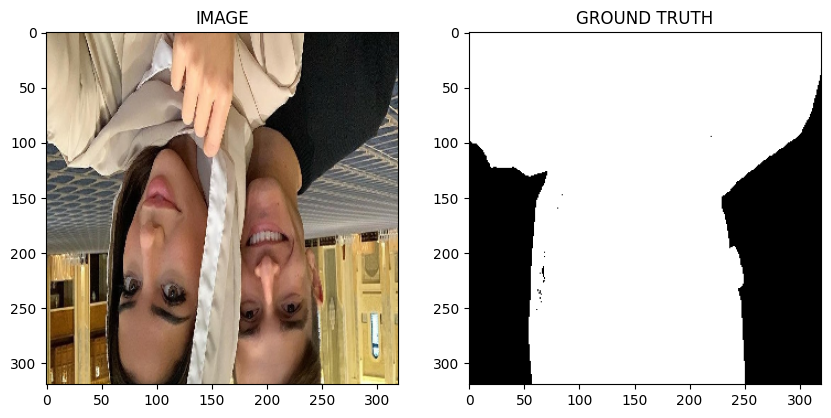

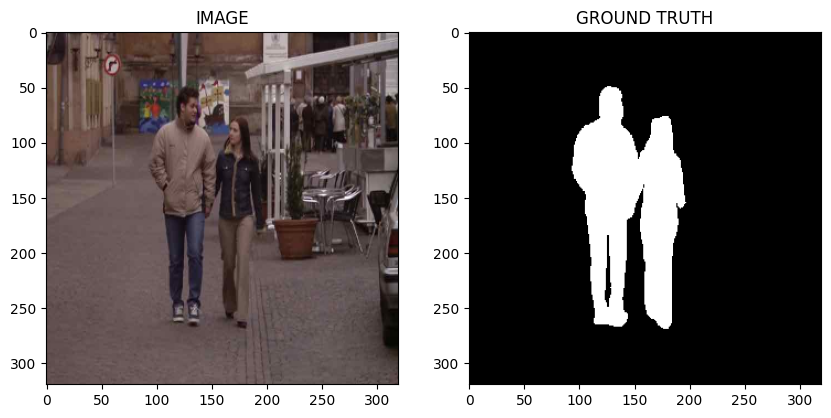

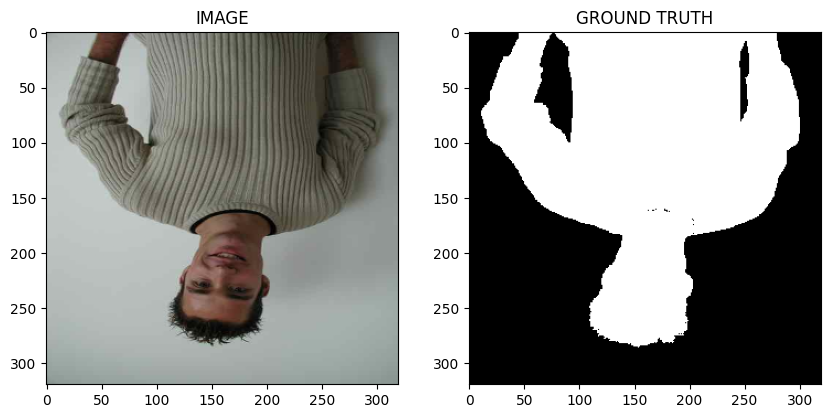

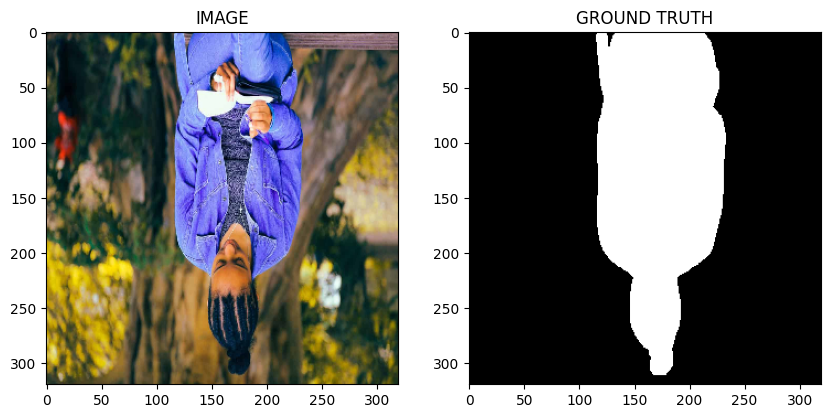

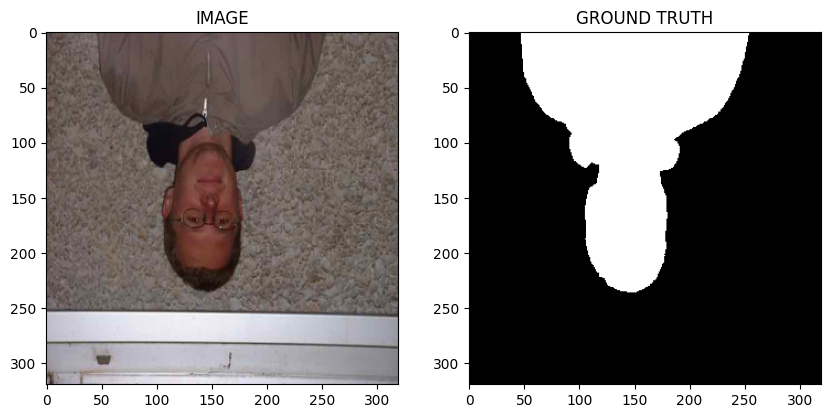

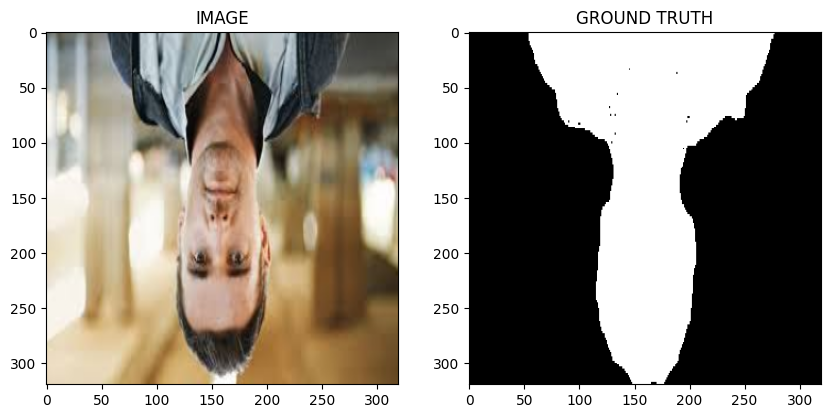

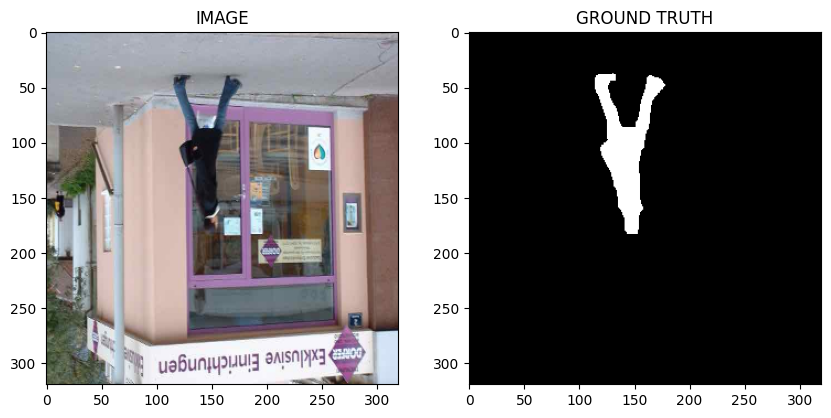

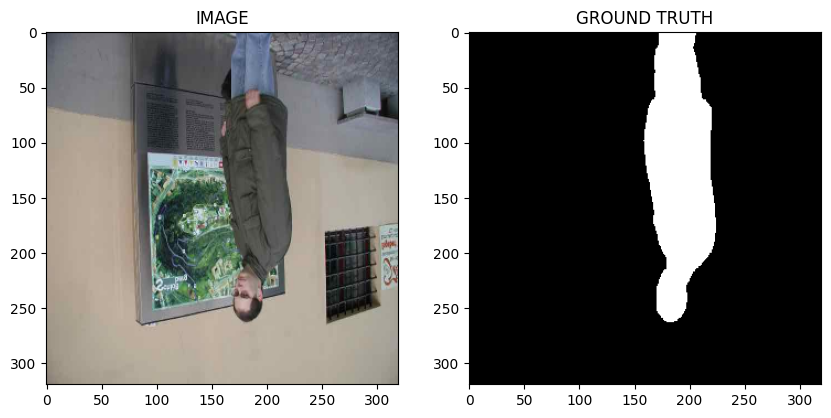

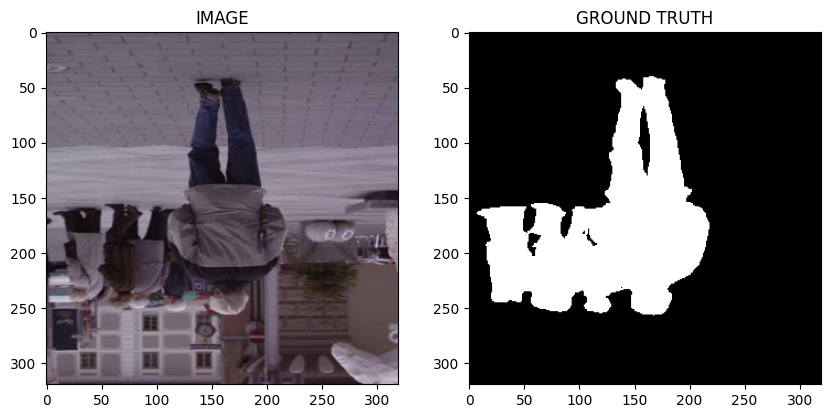

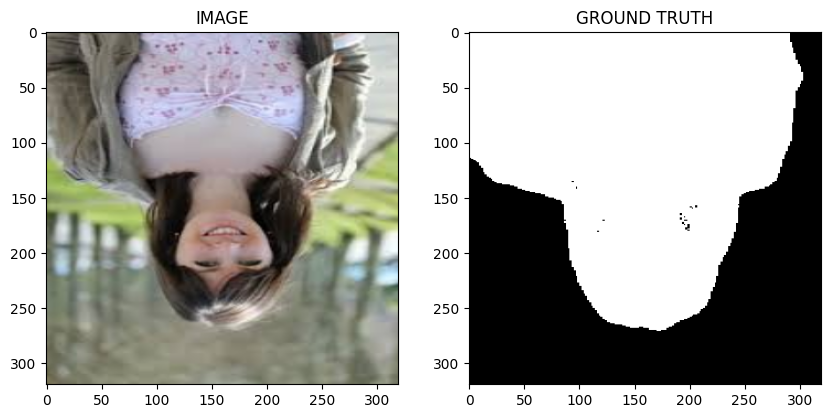

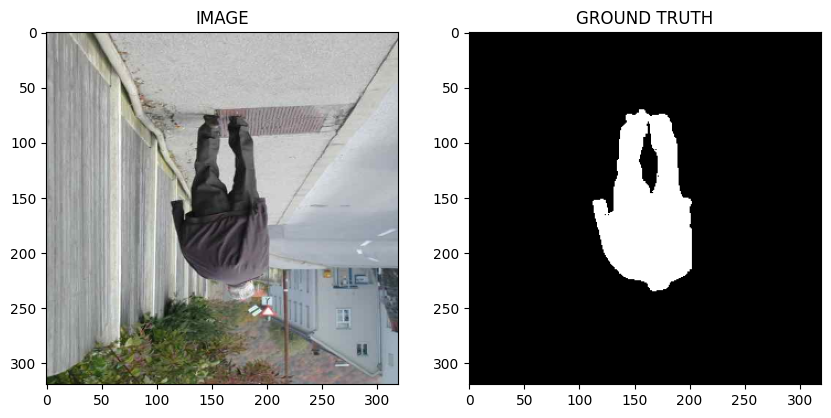

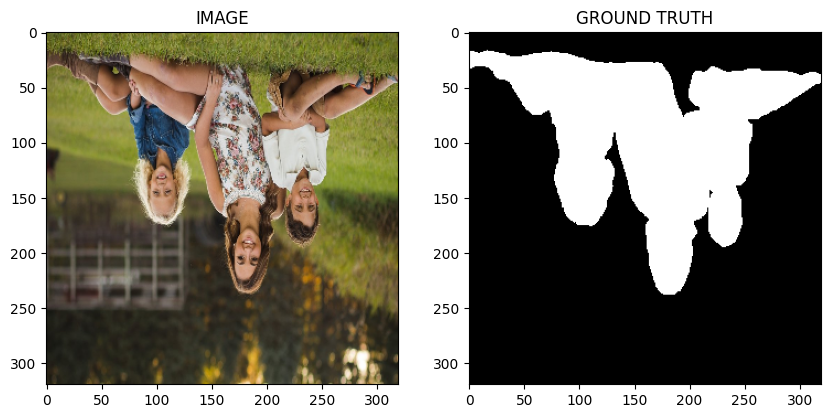

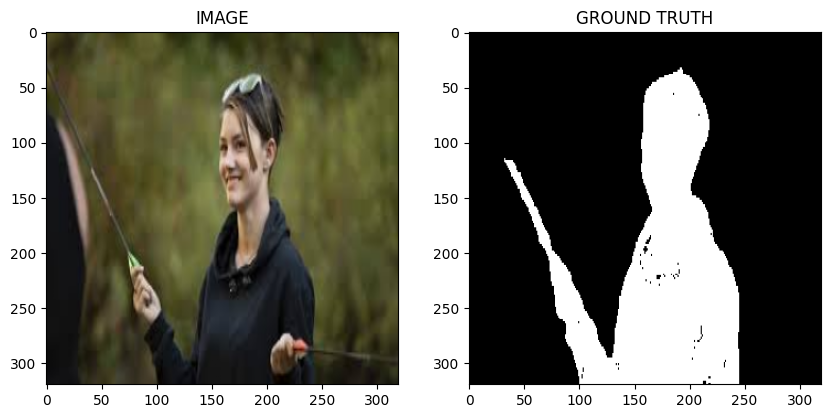

In [ ]:
# plotting some of the images
for idx in range(23,40):
  image, mask = trainset[idx]
  helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [ ]:
# check the number of batches in each loader
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
# lets check the shape of one batch
for image, mask in trainloader:
  break
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
# we are going to use U-net as segmentation model (it as two parts: encoder and decoder)
# efficient net b0 -> encoder

# lets start by importing smp (segmentation model of pytorch)
from torch import nn
import segmentation_models_pytorch as smp

# we also need a loss fucntion for training
# we are going to use DiceLoss
from segmentation_models_pytorch.losses import DiceLoss


In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1, #problem is binary
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)
# if we put a semicolon (;) at the edn of the last line
# the output will be erased but the code will run
# and the weights and layers will be downloaded as well

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 15.5MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
  # we will train the model here so it know that it has to use batchnorm and dropout layers
  model.train()
  total_loss = 0.0 # initially

  # in order to match the number of matches we will use tqdm
  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    # make sure gradients are zero
    optimizer.zero_grad()

    logits, loss = model(images, masks)
    loss.backward() # back propagation for training and for finding gradients
    optimizer.step() # for weights upgradation

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
# similarly for eval function with some changes
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0 # initially

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
# lets start by initializng the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
# lets start our training loop
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    # we are going to save our model then
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print (f"Epoch : {i+1} Train loss : {train_loss} Valid loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


SAVED-MODEL
Epoch : 1 Train loss : 0.772841606537501 Valid loss : 3.5080549716949463


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


SAVED-MODEL
Epoch : 2 Train loss : 0.37990174690882367 Valid loss : 0.369930911809206


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


SAVED-MODEL
Epoch : 3 Train loss : 0.2636745423078537 Valid loss : 0.3201046586036682


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Epoch : 4 Train loss : 0.2812853862841924 Valid loss : 0.3550392612814903


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


SAVED-MODEL
Epoch : 5 Train loss : 0.25651711225509644 Valid loss : 0.24608214199543


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


SAVED-MODEL
Epoch : 6 Train loss : 0.22222522695859273 Valid loss : 0.2405479997396469


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Epoch : 7 Train loss : 0.20784387489159903 Valid loss : 0.30172546207904816


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


SAVED-MODEL
Epoch : 8 Train loss : 0.177082160115242 Valid loss : 0.20238981395959854


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


SAVED-MODEL
Epoch : 9 Train loss : 0.16465652485688528 Valid loss : 0.1873554214835167


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch : 10 Train loss : 0.14286894301573436 Valid loss : 0.21438724547624588


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch : 11 Train loss : 0.17949722607930502 Valid loss : 0.20201082155108452


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


Epoch : 12 Train loss : 0.16481039971113204 Valid loss : 0.18818213418126106


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 13 Train loss : 0.14034760892391204 Valid loss : 0.25552529469132423


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch : 14 Train loss : 0.12631607751051585 Valid loss : 0.23244434222579002


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 15 Train loss : 0.1254866451025009 Valid loss : 0.20131701231002808


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch : 16 Train loss : 0.17794697533051174 Valid loss : 0.27827059105038643


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Epoch : 17 Train loss : 0.19138826578855514 Valid loss : 0.23319882526993752


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch : 18 Train loss : 0.15175146609544754 Valid loss : 0.2533237412571907


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 19 Train loss : 0.17726544986168544 Valid loss : 0.32207099348306656


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch : 20 Train loss : 0.160374520222346 Valid loss : 0.2549856901168823


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 21 Train loss : 0.12159434109926223 Valid loss : 0.27477335184812546


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Epoch : 22 Train loss : 0.13955704420804976 Valid loss : 0.24964440986514091


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch : 23 Train loss : 0.16035977552334468 Valid loss : 0.27863919734954834


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 24 Train loss : 0.12746988336245219 Valid loss : 0.20214864239096642


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch : 25 Train loss : 0.10420290331045787 Valid loss : 0.1907230094075203


# Task 9 : Inference

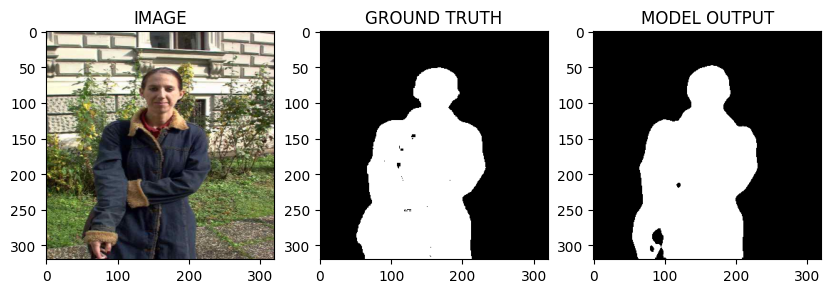

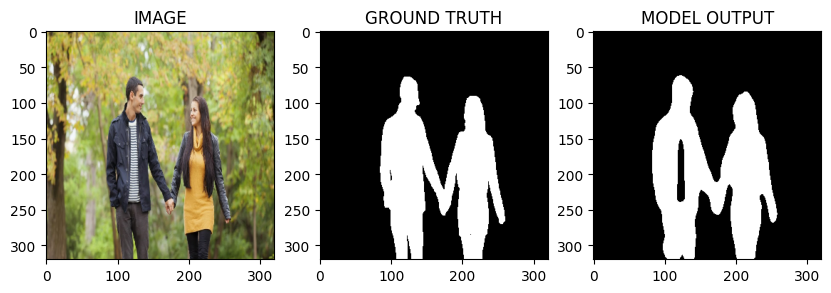

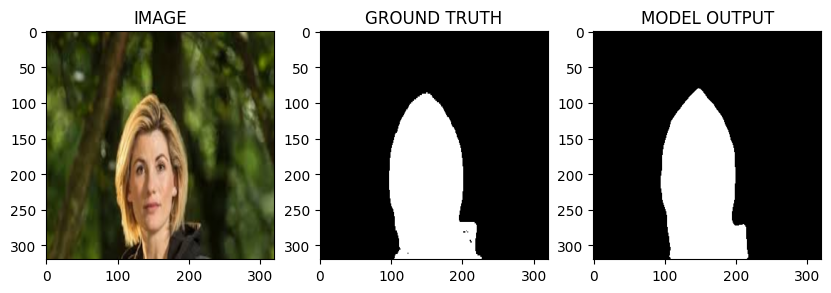

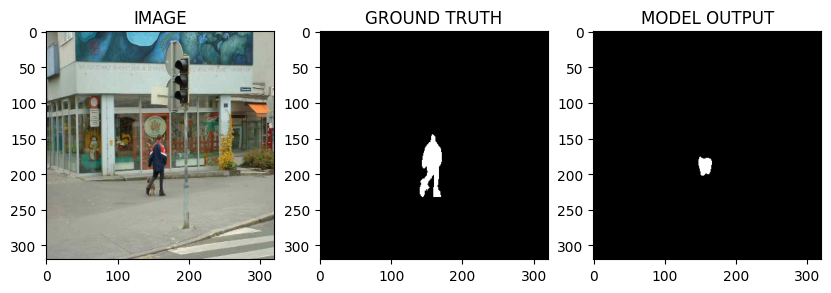

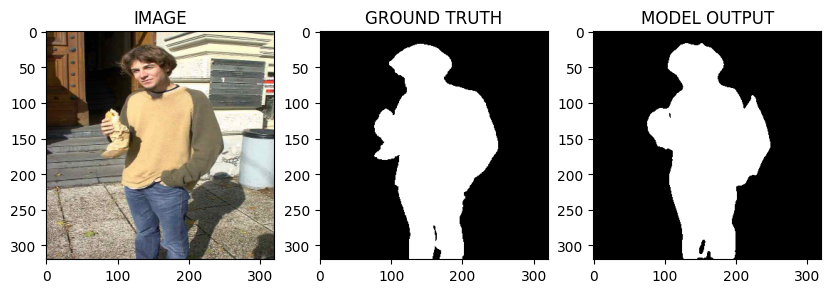

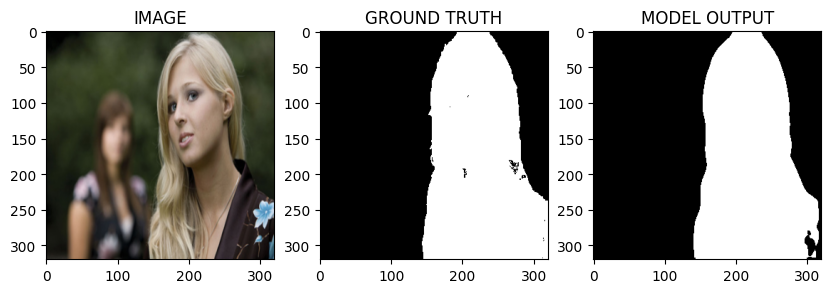

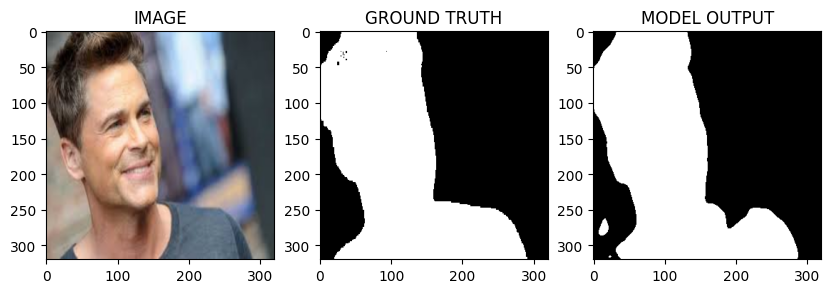

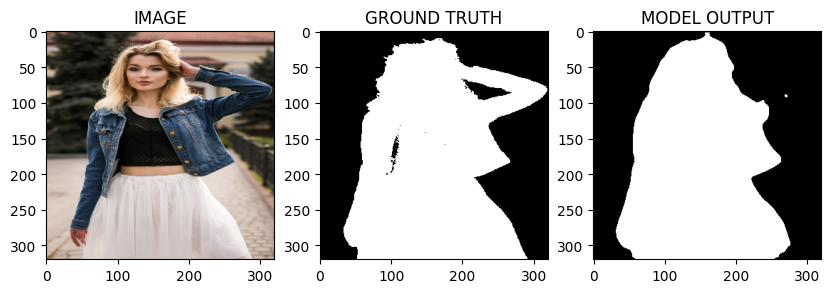

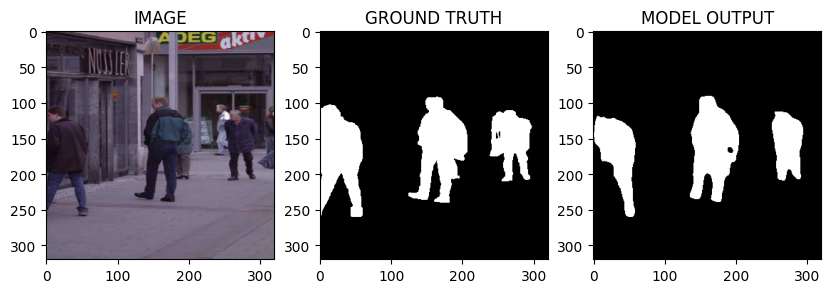

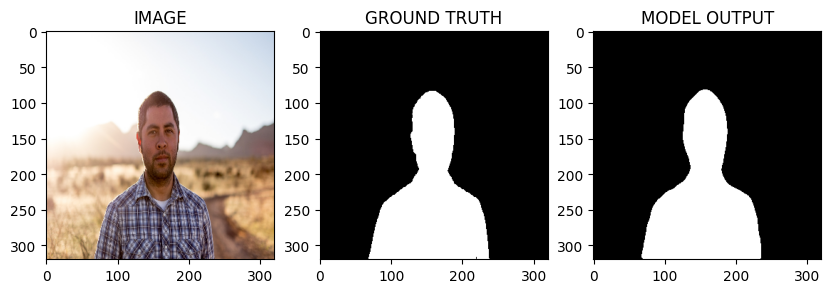

In [ ]:
# now we will use the best model (saved in file explorer) to make predictions
# in short we are going to make inference (predictions)

for idx in range(12,22):
  # loading model
  model.load_state_dict(torch.load("/content/best_model.pt"))

  image, mask = validset[idx]

  # by unsequeeze(0) we are adding a new dimension, In this case Batch dimension
  # (c, h, w) -> (b, c, h, w)
  logits_mask = model(image.to(DEVICE).unsqueeze(0))
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > 0.5) * 1.0

  # now lets visualization function from the helper function
  # squeeze(0) will be used to discard the batch dimension
  helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))